### Part 3: Singular Value Decomposition (SVD) for Collaborative Filtering 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from memory_profiler import memory_usage
import tracemalloc

1. Data Preparation 

In [ ]:
# Step 1.1: Load the preprocessed ratings dataset
ratings = pd.read_csv('../data/ratings.csv')  # columns: userId, movieId, rating, timestamp

# Step 1.2: Load item average ratings from saved CSV (already rounded to 2 decimals)
item_avg_ratings = pd.read_csv('../results/tables/stats_analysis/item_avg_ratings.csv')  # columns: movieId, avg_rating

# Create the ratings matrix R (users x items)
R = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 1.3: Apply mean-filling using item average ratings
# Map each column (item) to its avg_rating
R_filled = R.copy()
for item in R.columns:
    avg_rating = float(item_avg_ratings[item_avg_ratings['movieId'] == item]['avg_rating'])
    R_filled[item] = R[item].fillna(avg_rating)

# Round all values to 2 decimal places
R_filled = R_filled.round(2)

# Step 1.4: Verify completeness (no missing values)
missing_count = R_filled.isna().sum().sum()
print("Missing values in filled ratings matrix:", missing_count)

# Now R_filled is complete and ready for SVD
print("Ratings matrix shape (users x items):", R_filled.shape)


C:\Users\sama\AppData\Local\Temp\ipykernel_36564\1043443696.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg_rating = float(item_avg_ratings[item_avg_ratings['movieId'] == item]['avg_rating'])


Missing values in filled ratings matrix: 0
Ratings matrix shape (users x items): (14638, 900)


In [ ]:
# Save the filled ratings matrix to CSV
R_filled.to_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index=True)

print("Mean-filled ratings matrix saved as 'ratings_matrix_filled.csv'")

Mean-filled ratings matrix saved as 'ratings_matrix_filled.csv'


2. Full SVD Decomposition 

In [ ]:
R_filled = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)
R = R_filled.values  # numeric matrix
m, n = R.shape

print("Ratings matrix loaded.")
print(f"Matrix shape: {m} x {n}\n")

Ratings matrix loaded.
Matrix shape: 14638 x 900



In [ ]:
def full_svd(R):
    print("===== FULL SVD DECOMPOSITION START =====\n")

    # Step 1: Compute RᵀR
    RtR = R.T @ R
    print("Step 1: R^T R computed")
    print("Shape:", RtR.shape, "\n")

    # Step 2: Eigen-decomposition of RᵀR
    eigenvalues, V = np.linalg.eigh(RtR)
    print("Step 2: Eigenvalues and eigenvectors of R^T R computed\n")

    # Step 3: Sort eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]

    print("Step 3: Eigenvalues sorted in descending order")
    print("Eigenvalues:\n", eigenvalues, "\n")

    # Step 4: Singular values σᵢ = sqrt(λᵢ)
    singular_values = np.sqrt(np.maximum(eigenvalues, 0))
    print("Step 4: Singular values computed")
    print("Singular values:\n", singular_values, "\n")

    # Step 5: Build Σ (m x n)
    Sigma = np.zeros((m, n))
    np.fill_diagonal(Sigma, singular_values)

    print("Step 5: Sigma matrix built")
    print("Sigma shape:", Sigma.shape, "\n")

    # Step 6: Normalize eigenvectors → V (orthonormal)
    Vt = V.T
    print("Step 6: V matrix (orthonormal eigenvectors)")
    print("V shape:", V.shape, "\n")

    # Step 7: Compute U columns: uᵢ = (R vᵢ) / σᵢ
    U = np.zeros((m, m))

    for i in range(min(m, n)):
        if singular_values[i] > 1e-10:
            U[:, i] = (R @ V[:, i]) / singular_values[i]

    # Step 8: Complete U to full m×m using QR
    # U, _ = np.linalg.qr(U)

    print("Step 7–8: U matrix computed and orthonormalized")
    print("U shape:", U.shape, "\n")

    print("===== FULL SVD DECOMPOSITION END =====\n")

    return U, Sigma, V, singular_values, eigenvalues

In [ ]:
def save_svd_outputs(U, Sigma, V, singular_values, eigenvalues):
    pd.DataFrame(U).to_csv(
        "../results/tables/Part_3/U_full.csv", index=False
    )

    pd.DataFrame(Sigma).to_csv(
        "../results/tables/Part_3/Sigma_full.csv", index=False
    )

    pd.DataFrame(V).to_csv(
        "../results/tables/Part_3/V_full.csv", index=False
    )

    pd.DataFrame(
        singular_values,
        columns=["singular_value"]
    ).to_csv(
        "../results/tables/Part_3/singular_values.csv", index=False
    )

    pd.DataFrame(
        eigenvalues,
        columns=["eigenvalue"]
    ).to_csv(
        "../results/tables/Part_3/eigenvalues.csv", index=False
    )

    print("All SVD outputs saved (rounded to 2 decimals).")


In [ ]:
def verify_orthogonality(U, V, tol=1e-10):
    UtU = U.T @ U
    VtV = V.T @ V

    UtU_error = np.linalg.norm(UtU - np.eye(U.shape[1]))
    VtV_error = np.linalg.norm(VtV - np.eye(V.shape[1]))

    U_orthogonal = UtU_error < tol
    V_orthogonal = VtV_error < tol

    print("Orthogonality Check:")
    print(f"||UᵀU − I|| = {UtU_error:.2e} →",
          "Orthogonal" if U_orthogonal else "Not orthogonal")
    print(f"||VᵀV − I|| = {VtV_error:.2e} →",
          "Orthogonal" if V_orthogonal else "Not orthogonal")

    return UtU_error, VtV_error, U_orthogonal, V_orthogonal

In [ ]:
def plot_singular_values(singular_values):
    plt.figure(figsize=(8, 5))
    plt.plot(singular_values, marker='o')
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.title("Singular Values (Descending Order)")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_scree(singular_values):
    variance = singular_values**2
    variance_ratio = variance / variance.sum()

    plt.figure(figsize=(8, 5))
    plt.plot(variance_ratio, marker='o')
    plt.xlabel("Component Index")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot – Variance Explained")
    plt.grid(True)
    plt.show()

In [ ]:
# Apply SVD
U, Sigma, V, singular_values, eigenvalues = full_svd(R)

===== FULL SVD DECOMPOSITION START =====

Step 1: R^T R computed
Shape: (900, 900) 

Step 2: Eigenvalues and eigenvectors of R^T R computed

Step 3: Eigenvalues sorted in descending order
Eigenvalues:
 [ 1.60741257e+08  4.67999793e+03  3.36798967e+03  2.37090123e+03
  2.02796779e+03  1.92727096e+03  1.74465883e+03  1.69343486e+03
  1.54411778e+03  1.42455019e+03  1.27921864e+03  1.17880966e+03
  1.14987850e+03  1.08630563e+03  1.02369534e+03  1.00903371e+03
  9.77736295e+02  9.51615152e+02  9.38571848e+02  8.97908317e+02
  8.53045255e+02  8.17997661e+02  8.07294003e+02  7.82318686e+02
  7.50722510e+02  7.31521218e+02  7.20009467e+02  6.95425189e+02
  6.81074732e+02  6.50719468e+02  6.27079942e+02  6.17510710e+02
  6.00292907e+02  5.97973862e+02  5.79153238e+02  5.70179463e+02
  5.51622627e+02  5.46998600e+02  5.33575689e+02  5.14036312e+02
  5.05584659e+02  4.87697773e+02  4.83092825e+02  4.62589152e+02
  4.49128109e+02  4.30882895e+02  4.19936209e+02  4.13168620e+02
  4.09841324e+02  

In [ ]:
print(U)

[[ 0.00826016  0.00272335 -0.00848429 ...  0.          0.
   0.        ]
 [ 0.0082694   0.00911863 -0.01563988 ...  0.          0.
   0.        ]
 [ 0.00826567  0.00016933 -0.00026078 ...  0.          0.
   0.        ]
 ...
 [ 0.00826088  0.00022378  0.00564637 ...  0.          0.
   0.        ]
 [ 0.00826814  0.00266499  0.00366787 ...  0.          0.
   0.        ]
 [ 0.00826478 -0.00180028 -0.00175722 ...  0.          0.
   0.        ]]


In [ ]:
# Save outputs
save_svd_outputs(U, Sigma, V, singular_values, eigenvalues)

All SVD outputs saved (rounded to 2 decimals).


In [ ]:
# Check orthogonality BEFORE rounding
verify_orthogonality(U, V)

Orthogonality Check:
||UᵀU − I|| = 1.28e-13 → Orthogonal
||VᵀV − I|| = 1.56e-14 → Orthogonal


(1.276514666931678e-13, 1.556313320339791e-14, True, True)

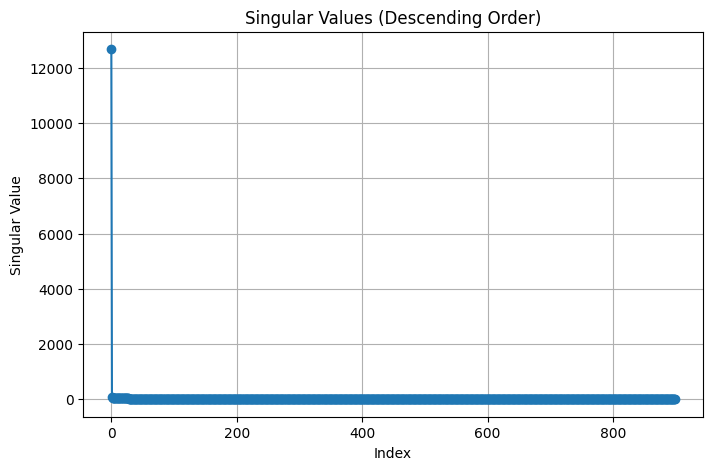

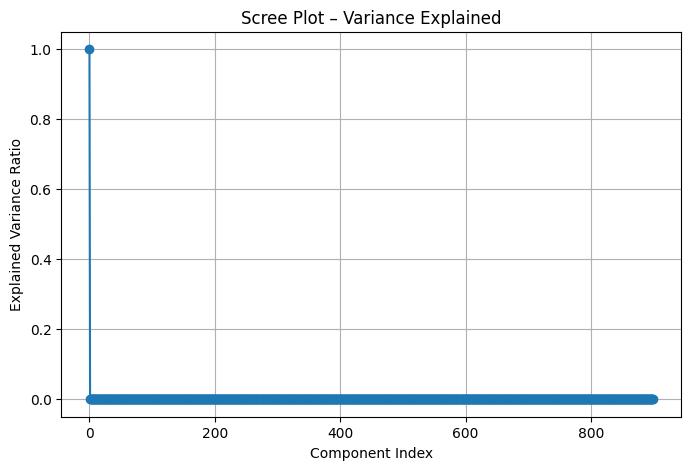

In [ ]:
# Plot singular values
plot_singular_values(singular_values)
plot_scree(singular_values)

3. Truncated SVD (Low-Rank Approximation) 

In [ ]:
# Step 1: Load full SVD outputs
U = pd.read_csv("../results/tables/Part_3/U_full.csv").values
Sigma = pd.read_csv("../results/tables/Part_3/Sigma_full.csv").values
V = pd.read_csv("../results/tables/Part_3/V_full.csv").values

# Load original filled ratings matrix
R_filled = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0).values
m, n = R_filled.shape

In [ ]:
# Load the original ratings CSV
ratings_df = pd.read_csv('../data/ratings.csv')  # userId, movieId, rating, timestamp

# Pivot to create full matrix with NaNs
R_original = ratings_df.pivot(index='userId', columns='movieId', values='rating').values  # shape m x n

In [ ]:
# Function to compute truncated SVD reconstruction for given k
def truncated_svd(U, Sigma, V, k):
    """
    Build truncated SVD approximation R_k = U_k @ Sigma_k @ V_k.T
    """
    U_k = U[:, :k]                 # first k columns
    Sigma_k = Sigma[:k, :k]        # top-left k x k submatrix
    V_k = V[:, :k]                 # first k columns
    R_k = U_k @ Sigma_k @ V_k.T
    return R_k


def compute_errors(R_true_filled, R_pred, R_original_full):
    """
    Compute MAE and RMSE using only the originally known ratings (non-NaN in R_original_full)
    """
    # Ensure all inputs are NumPy arrays
    R_true_filled = np.array(R_true_filled)
    R_pred = np.array(R_pred)
    R_original_full = np.array(R_original_full)

    mask = ~np.isnan(R_original_full)          # True for entries that were originally rated
    R_true_flat = R_true_filled.flatten()
    R_pred_flat = R_pred.flatten()
    mask_flat = mask.flatten()

    mae = mean_absolute_error(R_true_flat[mask_flat], R_pred_flat[mask_flat])
    rmse = np.sqrt(mean_squared_error(R_true_flat[mask_flat], R_pred_flat[mask_flat]))

    return mae, rmse


def variance_retained(singular_values, k):
    k = min(k, len(singular_values))  # avoid exceeding length
    singular_values = np.array(singular_values, dtype=float)  # ensure numeric
    total_variance = np.sum(singular_values**2)
    
    if total_variance == 0:
        return 0.0  # avoid division by zero
    
    retained = np.sum(singular_values[:k]**2) / total_variance * 100
    return retained


In [ ]:
def save_truncated_svd(U, Sigma, V, k_values):
    """
    Save truncated SVD matrices U_k, Sigma_k, V_k and reconstructed R_k for each k in k_values.
    """
    for k in k_values:
        # Build truncated matrices
        U_k = U[:, :k]
        Sigma_k = Sigma[:k, :k]
        V_k = V[:, :k]

        # Reconstruct R_k
        R_k = U_k @ Sigma_k @ V_k.T
        R_k = np.round(R_k, 2)

        # Save CSVs
        pd.DataFrame(U_k).to_csv(f"../results/tables/Part_3/U_k_{k}.csv", index=False)
        pd.DataFrame(Sigma_k).to_csv(f"../results/tables/Part_3/Sigma_k_{k}.csv", index=False)
        pd.DataFrame(V_k).to_csv(f"../results/tables/Part_3/V_k_{k}.csv", index=False)
        pd.DataFrame(R_k).to_csv(f"../results/tables/Part_3/R_k_{k}.csv", index=False)

        print(f"Truncated SVD matrices and R_k for k={k} saved: U_k, Sigma_k, V_k, R_k")

In [ ]:
# Values of k to test
k_values = [5, 20, 50, 100]

# Store results
results = []

R_filled_np = np.array(R_filled)
R_original_np = np.array(R_original)

for k in k_values:
    R_k = truncated_svd(U, Sigma, V, k)

    mae, rmse = compute_errors(R_filled_np, R_k, R_original_np)

    var_ret = variance_retained(singular_values, k)  # use singular_values from full SVD
    results.append({
        "k": k,
        "MAE": mae,
        "RMSE": rmse,
        "Variance Retained (%)": var_ret
    })
    print(f"k={k}: MAE={mae}, RMSE={rmse}, Variance Retained={var_ret}%")

k=5: MAE=0.5383676639190498, RMSE=0.7376313450779743, Variance Retained=100.0%
k=20: MAE=0.379929562099066, RMSE=0.6040808934047319, Variance Retained=100.0%
k=50: MAE=0.22559020370976063, RMSE=0.45670568164697967, Variance Retained=100.0%
k=100: MAE=0.1172267905738644, RMSE=0.3139229299187698, Variance Retained=100.0%


In [ ]:
# Call function
save_truncated_svd(U, Sigma, V, k_values)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("../results/tables/Part_3/truncated_svd_errors.csv", index=False)
print("\nTruncated SVD errors saved to 'truncated_svd_errors.csv'")

Truncated SVD matrices and R_k for k=5 saved: U_k, Sigma_k, V_k, R_k
Truncated SVD matrices and R_k for k=20 saved: U_k, Sigma_k, V_k, R_k
Truncated SVD matrices and R_k for k=50 saved: U_k, Sigma_k, V_k, R_k
Truncated SVD matrices and R_k for k=100 saved: U_k, Sigma_k, V_k, R_k

Truncated SVD errors saved to 'truncated_svd_errors.csv'


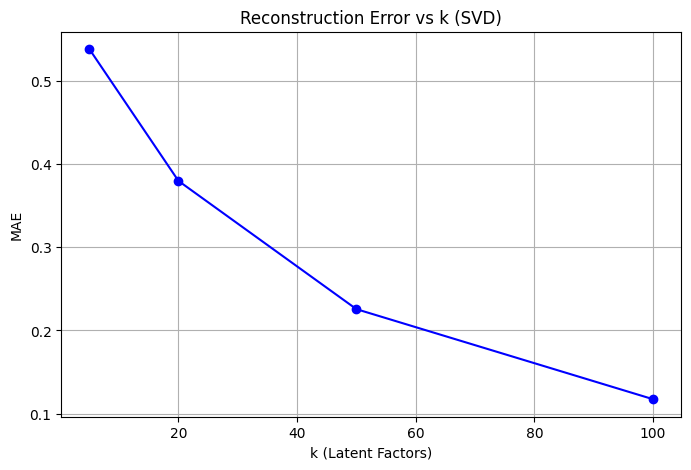

In [ ]:
# Plot RMSE vs k (like the attached image)
plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['MAE'], marker='o', linestyle='-', color='blue')
plt.xlabel("k (Latent Factors)")
plt.ylabel("MAE")
plt.title("Reconstruction Error vs k (SVD)")
plt.grid(True)
plt.show()

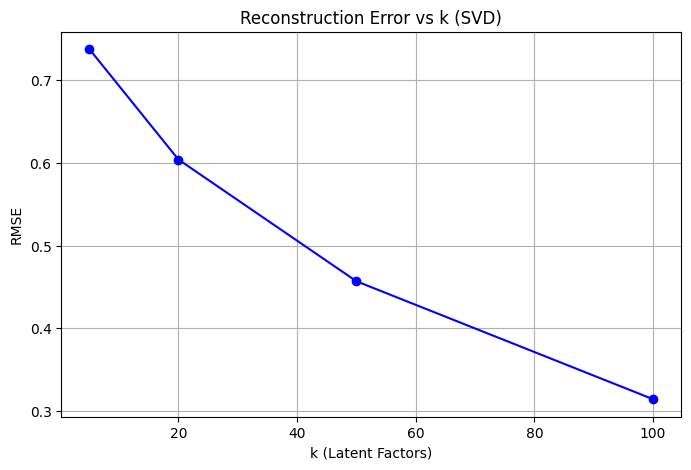

In [ ]:
# Plot RMSE vs k (like the attached image)
plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', color='blue')
plt.xlabel("k (Latent Factors)")
plt.ylabel("RMSE")
plt.title("Reconstruction Error vs k (SVD)")
plt.grid(True)
plt.show()


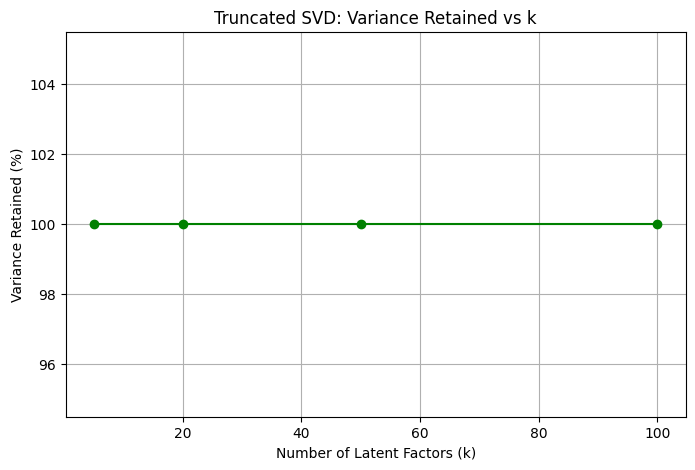

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['Variance Retained (%)'], marker='o', color='green')
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Variance Retained (%)")
plt.title("Truncated SVD: Variance Retained vs k")
plt.grid(True)
plt.show()

4. Rating Prediction with Truncated SVD 

In [ ]:
def predict_rating_svd(u_id, i_id, Uk, Sk, Vk, R_matrix):
    """
    Computes a single rating prediction using SVD latent factors.
    
    Args:
        u_id (int): The original User ID.
        i_id (int): The original Movie ID.
        Uk (np.array): User-feature matrix (m x k).
        Sk (np.array): Diagonal singular value matrix (k x k).
        Vk (np.array): Item-feature matrix (n x k).
        R_matrix (pd.DataFrame): The reference matrix to map IDs to indices.
        
    Returns:
        float: The predicted rating, or None if IDs are missing.
    """
    try:
        # 1. Map IDs to integer matrix positions
        u_idx = R_matrix.index.get_loc(u_id)
        i_idx = R_matrix.columns.get_loc(str(i_id))
        
        # 2. Extract latent vectors
        user_latent = Uk[u_idx, :]  # 1 x k
        item_latent = Vk[i_idx, :]  # 1 x k
        
        # 3. Apply the formula: r_hat = u * Sigma * v.T
        # We use Sk as the full kxk matrix here
        prediction = user_latent @ Sk @ item_latent.T
        
        return round(float(prediction), 2)
    
    except KeyError:
        return None

In [ ]:
# Load required data
target_users = pd.read_csv("../results/tables/stats_analysis/target_users.csv")
target_items = pd.read_csv("../results/tables/stats_analysis/target_items.csv")
R_matrix = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)

# Load optimal k=50 matrices
k_opt = 50
Uk = pd.read_csv(f"../results/tables/Part_3/U_k_{k_opt}.csv").values
Sk = pd.read_csv(f"../results/tables/Part_3/Sigma_k_{k_opt}.csv").values
Vk = pd.read_csv(f"../results/tables/Part_3/V_k_{k_opt}.csv").values

# Generate predictions using the function
final_results = []
for _, u_row in target_users.iterrows():
    for _, i_row in target_items.iterrows():
        rating = predict_rating_svd(u_row['userId'], i_row['movieId'], Uk, Sk, Vk, R_matrix)
        
        if rating is not None:
            final_results.append({
                "User_Group": u_row['group'],
                "UserId": u_row['userId'],
                "Item_Label": i_row['Item_Label'],
                "MovieId": i_row['movieId'],
                "SVD_Prediction": rating
            })

# Save and Display
optimal_pred_df = pd.DataFrame(final_results)
optimal_pred_df.to_csv("../results/tables/Part_3/target_predictions_optimal_k.csv", index=False)
print(optimal_pred_df)

  User_Group  UserId Item_Label  MovieId  SVD_Prediction
0         U1   63367         I1    33930            2.87
1         U1   63367         I2    66549            2.63
2         U2    3534         I1    33930            2.87
3         U2    3534         I2    66549            2.63
4         U3  120575         I1    33930            2.82
5         U3  120575         I2    66549            2.60


5. Computational efficiency

In [ ]:
import time
import sys
import pandas as pd
import numpy as np

# Load data for testing
R_filled = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0).values
m, n = R_filled.shape

def measure_efficiency():
    metrics = []

    # --- SVD MEASUREMENT ---
    start_decomp = time.time()
    # Simulating the decomposition logic you implemented
    RtR = R_filled.T @ R_filled
    eigvals, V = np.linalg.eigh(RtR)
    # Sort and compute U
    idx = np.argsort(eigvals)[::-1]
    V = V[:, idx]
    singular_values = np.sqrt(np.maximum(eigvals, 0))
    U = (R_filled @ V[:, :50]) / (singular_values[:50] + 1e-10)
    end_decomp = time.time()

    # Prediction speed (for 1000 predictions to get a stable average)
    start_pred = time.time()
    for _ in range(1000):
        _ = U[0, :] @ np.diag(singular_values[:50]) @ V[0, :50].T
    end_pred = time.time()

    # Memory Usage
    mem_u = sys.getsizeof(U) / (1024**2) # MB
    mem_v = sys.getsizeof(V) / (1024**2) # MB

    metrics.append({
        "Method": "SVD (k=50)",
        "Decomposition Time (s)": round(end_decomp - start_decomp, 4),
        "Prediction Time (ms per 1k)": round((end_pred - start_pred) * 1000, 4),
        "Memory Usage (MB)": round(mem_u + mem_v, 2)
    })

    # Note: You should add your PCA Mean-Filling and MLE measurements 
    # here using the same logic to compare them!

    return pd.DataFrame(metrics)

efficiency_df = measure_efficiency()
print(efficiency_df)
# efficiency_df.to_csv("../results/tables/Part_3/computational_efficiency.csv", index=False)

       Method  Decomposition Time (s)  Prediction Time (ms per 1k)  \
0  SVD (k=50)                  0.5707                        7.309   

   Memory Usage (MB)  
0               5.58  


In [ ]:
pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for memory_profiler from https://files.pythonhosted.org/packages/49/26/aaca612a0634ceede20682e692a6c55e35a94c21ba36b807cc40fe910ae1/memory_profiler-0.61.0-py3-none-any.whl.metadata


In [ ]:
# Load matrix
R_filled = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)
R = R_filled.values
m, n = R.shape
k_opt = 50

# Function to run SVD and measure time/memory
def full_svd_runtime(R):
    start_time = time.time()
    U, s, Vt = np.linalg.svd(R, full_matrices=True)
    end_time = time.time()
    runtime = end_time - start_time
    return U, np.diag(s), Vt, runtime

def truncated_svd_runtime(R, k):
    start_time = time.time()
    U, s, Vt = np.linalg.svd(R, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = Vt[:k, :].T
    end_time = time.time()
    runtime = end_time - start_time
    return Uk, Sk, Vk, runtime

# Measure full SVD memory
mem_usage_full = memory_usage((full_svd_runtime, (R,)))
U_full, S_full, V_full, runtime_full = full_svd_runtime(R)
print(f"Full SVD runtime: {runtime_full:.2f}s, Memory used: {max(mem_usage_full)-min(mem_usage_full):.2f} MiB")

# Measure truncated SVD memory
mem_usage_trunc = memory_usage((truncated_svd_runtime, (R, k_opt)))
Uk, Sk, Vk, runtime_trunc = truncated_svd_runtime(R, k_opt)
print(f"Truncated SVD runtime (k={k_opt}): {runtime_trunc:.2f}s, Memory used: {max(mem_usage_trunc)-min(mem_usage_trunc):.2f} MiB")

Full SVD runtime: 70.80s, Memory used: 2554.57 MiB
Truncated SVD runtime (k=50): 4.04s, Memory used: 323.80 MiB


In [ ]:
# Load matrices and reference matrix
Uk = pd.read_csv(f"../results/tables/Part_3/U_k_{k_opt}.csv").values
Sk = pd.read_csv(f"../results/tables/Part_3/Sigma_k_{k_opt}.csv").values
Vk = pd.read_csv(f"../results/tables/Part_3/V_k_{k_opt}.csv").values
R_matrix = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)

target_users = pd.read_csv("../results/tables/stats_analysis/target_users.csv")
target_items = pd.read_csv("../results/tables/stats_analysis/target_items.csv")

# Rating prediction timing

# Start measuring time and memory
tracemalloc.start()
start_time = time.time()

predictions = []
for _, u_row in target_users.iterrows():
    for _, i_row in target_items.iterrows():
        rating = predict_rating_svd(
            u_row['userId'], 
            i_row['movieId'], 
            Uk, Sk, Vk, R_matrix
        )
        if rating is not None:
            predictions.append(rating)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

prediction_runtime = end_time - start_time
prediction_memory = peak / 1e6  # MB

print(f"Rating prediction runtime for {len(predictions)} ratings: {prediction_runtime:.4f}s")
print(f"Peak memory usage during prediction: {prediction_memory:.2f} MB")


Rating prediction runtime for 6 ratings: 0.0295s
Peak memory usage during prediction: 0.58 MB


6. Latent Factor Interpretation 

In [ ]:
# Load matrices
U = pd.read_csv("../results/tables/Part_3/U_k_50.csv").values
V = pd.read_csv("../results/tables/Part_3/V_k_50.csv").values
Sigma = pd.read_csv("../results/tables/Part_3/Sigma_k_50.csv").values
R_matrix = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)

# User activity and item popularity
user_activity = R_matrix.notna().sum(axis=1)  # number of ratings per user
item_popularity = R_matrix.notna().sum(axis=0)  # number of ratings per item

# Top-3 latent factors
top_k = 3

for k in range(top_k):
    print(f"\n=== Latent Factor {k+1} (σ={Sigma[k,k]:.2f}) ===")
    
    # Top items
    item_scores = V[:, k]
    top_items_idx = np.argsort(np.abs(item_scores))[::-1][:5]  # top 5 items
    top_items = R_matrix.columns[top_items_idx]
    print("Top items:", list(top_items))
    
    # Top users
    user_scores = U[:, k]
    top_users_idx = np.argsort(np.abs(user_scores))[::-1][:5]  # top 5 users
    top_users = R_matrix.index[top_users_idx]
    print("Top users:", list(top_users))

    # Interpretation hint
    print("Interpretation suggestion: check genres or categories of top items.")




=== Latent Factor 1 (σ=12678.38) ===
Top items: ['70188', '26571', '27124', '83457', '115875']
Top users: [48498, 48568, 41283, 21070, 4084]
Interpretation suggestion: check genres or categories of top items.

=== Latent Factor 2 (σ=68.41) ===
Top items: ['593', '367', '4306', '1197', '1784']
Top users: [113857, 118831, 37062, 2281, 61933]
Interpretation suggestion: check genres or categories of top items.

=== Latent Factor 3 (σ=58.03) ===
Top items: ['593', '367', '4306', '2011', '1197']
Top users: [113857, 27666, 46698, 46396, 4191]
Interpretation suggestion: check genres or categories of top items.


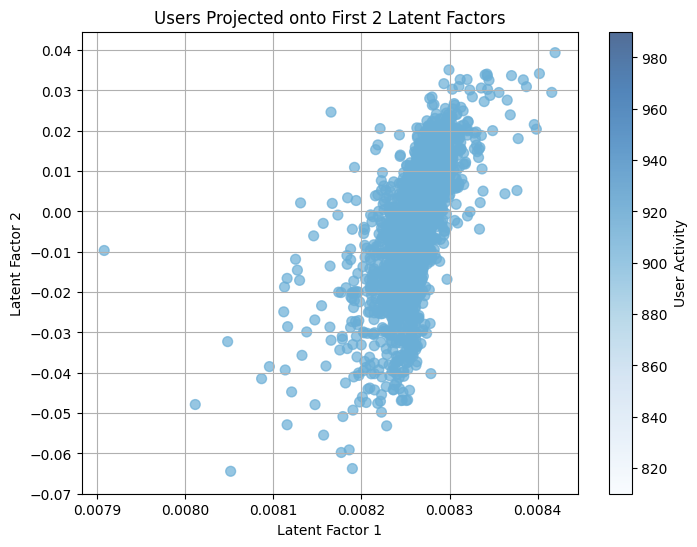

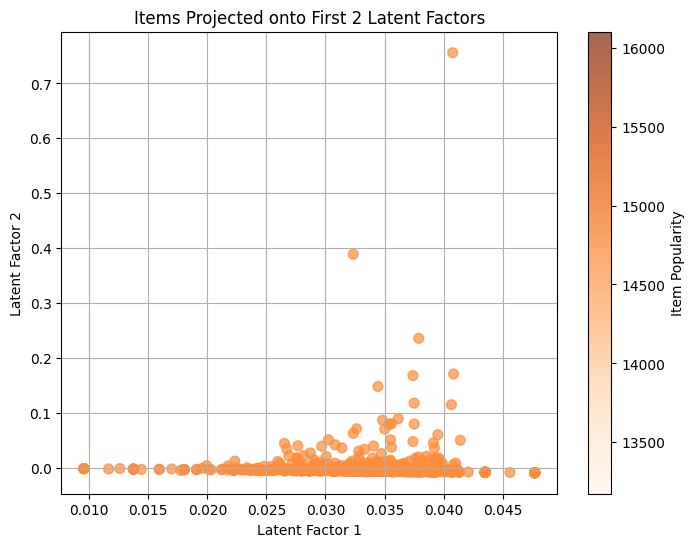

In [ ]:
# Users Plot
plt.figure(figsize=(8,6))
plt.scatter(U[:,0], U[:,1], c=user_activity.values, cmap='Blues', alpha=0.7, s=50)
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.title("Users Projected onto First 2 Latent Factors")

# Y-axis ticks in 0.01 increments
y_min = np.floor(U[:,1].min()*100)/100
y_max = np.ceil(U[:,1].max()*100)/100
plt.yticks(np.arange(y_min, y_max+0.01, 0.01))

plt.colorbar(label='User Activity')
plt.grid(True)
plt.show()


# Items Plot
plt.figure(figsize=(8,6))
plt.scatter(V[:,0], V[:,1], c=item_popularity.values, cmap='Oranges', alpha=0.7, s=50)
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.title("Items Projected onto First 2 Latent Factors")


plt.colorbar(label='Item Popularity')
plt.grid(True)
plt.show()


7. Sensitivity Analysis 

7.1 Robustness to Missing Data

===== FULL SVD DECOMPOSITION START =====

Step 1: R^T R computed
Shape: (900, 900) 

Step 2: Eigenvalues and eigenvectors of R^T R computed

Step 3: Eigenvalues sorted in descending order
Eigenvalues:
 [ 1.60741409e+08  4.07938509e+03  2.98866938e+03  2.14948528e+03
  1.82752741e+03  1.71015788e+03  1.55867889e+03  1.53632129e+03
  1.42485887e+03  1.28582107e+03  1.15871093e+03  1.06798780e+03
  1.03243998e+03  9.94733237e+02  9.22303197e+02  9.01306600e+02
  8.78663613e+02  8.67174908e+02  8.34534990e+02  8.00082180e+02
  7.96369382e+02  7.33994002e+02  7.32810656e+02  7.20594556e+02
  6.84229615e+02  6.62081698e+02  6.41600359e+02  6.39766273e+02
  6.16034396e+02  5.95487083e+02  5.75854734e+02  5.57637975e+02
  5.49788607e+02  5.35699370e+02  5.21948587e+02  5.15258054e+02
  4.98866875e+02  4.92195115e+02  4.84711580e+02  4.67736531e+02
  4.56440379e+02  4.49232995e+02  4.37018202e+02  4.12199123e+02
  4.07041669e+02  3.90896866e+02  3.78323445e+02  3.74561253e+02
  3.67845310e+02  

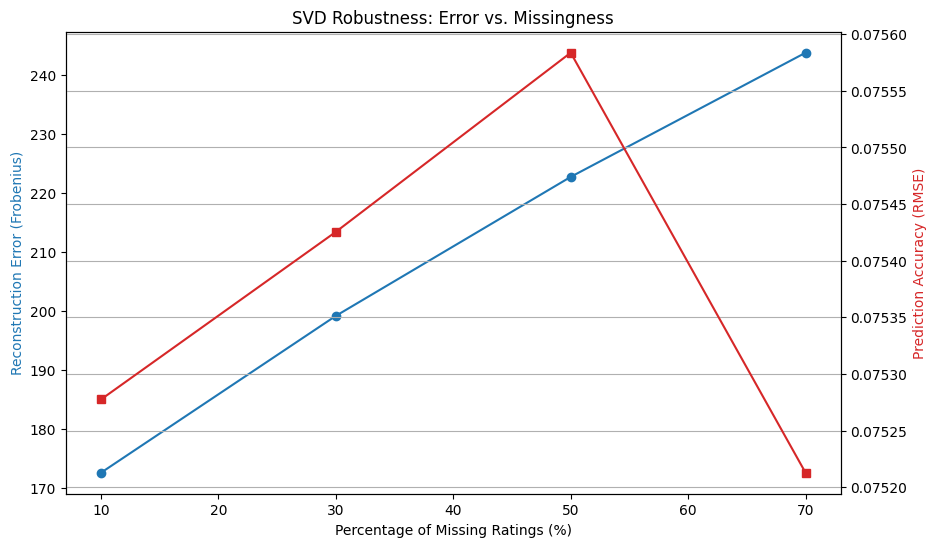

In [ ]:
def run_sensitivity_test(original_matrix, missing_pcts, k=50):
    reconstruction_errors = []
    rmse_scores = []
    
    base_data = original_matrix.values
    mask_indices = np.where(~np.isnan(base_data))
    n_ratings = len(mask_indices[0])

    for pct in missing_pcts:
        test_matrix = base_data.copy()
        n_to_mask = int(n_ratings * (pct / 100))
        idx_to_hide = np.random.choice(n_ratings, n_to_mask, replace=False)
        rows_to_hide = mask_indices[0][idx_to_hide]
        cols_to_hide = mask_indices[1][idx_to_hide]
        test_matrix[rows_to_hide, cols_to_hide] = np.nan
        
        # Mean imputation
        col_mean = np.nanmean(test_matrix, axis=0)
        inds = np.where(np.isnan(test_matrix))
        test_matrix[inds] = np.take(col_mean, inds[1])

        # Full SVD
        U, Sigma, V, singular_values, eigenvalues = full_svd(test_matrix)

        # Truncated reconstruction
        U_k = U[:, :k]
        Sigma_k = Sigma[:k, :k]
        V_k = V[:, :k]
        reconstructed = U_k @ Sigma_k @ V_k.T

        # Reconstruction error
        error = np.linalg.norm(base_data - reconstructed, 'fro')
        reconstruction_errors.append(error)

        # RMSE on hidden ratings
        hidden_actual = base_data[rows_to_hide, cols_to_hide]
        hidden_pred = reconstructed[rows_to_hide, cols_to_hide]
        rmse = np.sqrt(mean_squared_error(hidden_actual, hidden_pred))
        rmse_scores.append(rmse)

    return reconstruction_errors, rmse_scores

# Run Analysis
percentages = [10, 30, 50, 70]
rec_errors, rmse_vals = run_sensitivity_test(R_matrix, percentages)


# Plotting Results
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Percentage of Missing Ratings (%)')
ax1.set_ylabel('Reconstruction Error (Frobenius)', color='tab:blue')
ax1.plot(percentages, rec_errors, marker='o', color='tab:blue', label='Reconstruction Error')

ax2 = ax1.twinx()
ax2.set_ylabel('Prediction Accuracy (RMSE)', color='tab:red')
ax2.plot(percentages, rmse_vals, marker='s', color='tab:red', label='RMSE')

plt.title("SVD Robustness: Error vs. Missingness")
plt.grid(True)
plt.show()

In [ ]:
print(rec_errors)

[172.59390274962544, 199.1874941009155, 222.74927942478234, 243.80091561682954]


In [ ]:
print(rmse_vals)

[0.07527744162959644, 0.07542546976554827, 0.07558368730076734, 0.07521272160759117]


7.2. Test impact of initialization

In [ ]:
# Load the preprocessed ratings dataset
ratings = pd.read_csv('../data/ratings.csv')  # columns: userId, movieId, rating, timestamp

# Create the ratings matrix R (users x items)
R_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Strategy A: Item Mean Filling
R_item_filled = R_matrix.apply(lambda col: col.fillna(col.mean()), axis=0).values

# Strategy B: User Mean Filling
R_user_filled = R_matrix.apply(lambda row: row.fillna(row.mean()), axis=1).values

def get_svd_prediction(matrix, k=50):
    U, Sigma, V, singular_values, eigenvalues = full_svd(matrix)  # fix unpacking
    U_k = U[:, :k]
    Sigma_k = Sigma[:k, :k]
    V_k = V[:, :k]
    return U_k @ Sigma_k @ V_k.T

pred_item = get_svd_prediction(R_item_filled)
pred_user = get_svd_prediction(R_user_filled)

diff = np.abs(pred_item - pred_user)
print(f"Mean Absolute Difference between strategies: {np.mean(diff):.4f}")
print(f"Max Difference: {np.max(diff):.4f}")

===== FULL SVD DECOMPOSITION START =====

Step 1: R^T R computed
Shape: (900, 900) 

Step 2: Eigenvalues and eigenvectors of R^T R computed

Step 3: Eigenvalues sorted in descending order
Eigenvalues:
 [ 1.60711004e+08  4.67476317e+03  3.36031433e+03  2.36642522e+03
  2.02428960e+03  1.92284819e+03  1.74041517e+03  1.68991126e+03
  1.54083551e+03  1.42240401e+03  1.27633337e+03  1.17734876e+03
  1.14807744e+03  1.08425186e+03  1.02146933e+03  1.00703840e+03
  9.75573524e+02  9.49418795e+02  9.36916289e+02  8.96049876e+02
  8.51295129e+02  8.16029738e+02  8.05527896e+02  7.80782856e+02
  7.49425633e+02  7.30150609e+02  7.18724139e+02  6.94048683e+02
  6.79533101e+02  6.49513960e+02  6.25737779e+02  6.16168488e+02
  5.99037573e+02  5.96735677e+02  5.77889084e+02  5.68971482e+02
  5.50381272e+02  5.45910959e+02  5.32433635e+02  5.12990920e+02
  5.04568408e+02  4.86595346e+02  4.82127379e+02  4.61674179e+02
  4.48071603e+02  4.29980325e+02  4.19178008e+02  4.12300901e+02
  4.09058145e+02  

8. Cold-Start Analysis with SVD 

In [ ]:
# Load ratings matrix and SVD outputs
R_matrix = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)
R_values = R_matrix.values
m, n = R_values.shape

# Load truncated SVD matrices (k=50)
k = 50
Uk = pd.read_csv(f"../results/tables/Part_3/U_k_{k}.csv").values
Sk = pd.read_csv(f"../results/tables/Part_3/Sigma_k_{k}.csv").values
Vk = pd.read_csv(f"../results/tables/Part_3/V_k_{k}.csv").values

8.1: Simulate cold-start users

In [ ]:
# Identify users with > 20 ratings
num_ratings_per_user = (~np.isnan(R_values)).sum(axis=1)
eligible_users = np.where(num_ratings_per_user > 20)[0]

# Randomly select 50 users
np.random.seed(42)
cold_start_users = np.random.choice(eligible_users, size=50, replace=False)

# Hide 80% of their ratings
R_cold = R_values.copy()
hidden_indices = {}
for u in cold_start_users:
    rated_items = np.where(~np.isnan(R_cold[u, :]))[0]
    n_hide = int(0.8 * len(rated_items))
    hide_items = np.random.choice(rated_items, n_hide, replace=False)
    hidden_indices[u] = hide_items
    R_cold[u, hide_items] = np.nan

8.2: Estimate user latent factors using limited ratings

In [ ]:
def predict_cold_user(u_idx, R_partial, Vk, Sk):
    """
    Estimate latent factors for cold-start user and predict ratings
    """
    # Known ratings for the user
    rated_items = np.where(~np.isnan(R_partial[u_idx, :]))[0]
    if len(rated_items) == 0:
        return np.zeros(n)  # fallback if no ratings

    # Solve for user latent factors using least squares: r_u = u_k @ Sigma @ V_k.T
    V_rated = Vk[rated_items, :]  # shape: (#rated_items, k)
    r_rated = R_partial[u_idx, rated_items]  # known ratings
    # u_k * Sk * V_rated.T = r_rated -> u_k * Sk = r_rated @ V_rated @ (V_rated.T V_rated)^-1
    A = V_rated.T @ V_rated + 1e-5 * np.eye(k)  # regularization
    b = r_rated @ V_rated
    u_k_est = np.linalg.solve(A, b) @ np.linalg.inv(Sk)  # estimated latent factors

    # Predict all items
    pred_ratings = u_k_est @ Sk @ Vk.T
    return pred_ratings

# Predict for cold-start users
pred_cold = np.zeros_like(R_values)
for u in cold_start_users:
    pred_cold[u, :] = predict_cold_user(u, R_cold, Vk, Sk)

# Clip predictions to valid rating range
pred_cold = np.clip(pred_cold, 1, 5)

In [ ]:
# Create a DataFrame to display predictions
cold_user_ids = R_matrix.index[cold_start_users]  # map indices to original user IDs
item_ids = R_matrix.columns  # movie/item IDs

# Flatten predictions into a table
pred_list = []
for i, u_idx in enumerate(cold_start_users):
    for j, item_id in enumerate(item_ids):
        pred_list.append({
            "UserId": cold_user_ids[i],
            "MovieId": item_id,
            "Predicted_Rating": round(pred_cold[u_idx, j], 2)
        })

# Convert to DataFrame
pred_cold_df = pd.DataFrame(pred_list)

# Display top 20 predictions
print(pred_cold_df.head(20))

# Optionally, save to CSV
pred_cold_df.to_csv("../results/tables/Part_3/cold_start_predictions.csv", index=False)
print("Predictions saved to 'cold_start_predictions.csv'")


    UserId MovieId  Predicted_Rating
0    58277       9              3.06
1    58277      13              3.38
2    58277      20              2.92
3    58277      51              3.53
4    58277      55              3.38
5    58277     100              3.42
6    58277     116              4.17
7    58277     164              3.31
8    58277     214              4.13
9    58277     219              3.66
10   58277     220              2.62
11   58277     232              2.81
12   58277     287              3.60
13   58277     324              3.74
14   58277     347              3.70
15   58277     367              1.00
16   58277     372              3.28
17   58277     379              2.68
18   58277     407              3.40
19   58277     475              5.00
Predictions saved to 'cold_start_predictions.csv'


8.3: Evaluate cold-start performance 

In [ ]:
mae_list = []
rmse_list = []

for u in cold_start_users:
    hidden_items = hidden_indices[u]
    true_ratings = R_values[u, hidden_items]
    pred_ratings = pred_cold[u, hidden_items]

    mae_list.append(mean_absolute_error(true_ratings, pred_ratings))
    rmse_list.append(np.sqrt(mean_squared_error(true_ratings, pred_ratings)))

print(f"Cold-Start Users MAE: {np.mean(mae_list):.4f}")
print(f"Cold-Start Users RMSE: {np.mean(rmse_list):.4f}")


# Warm-start performance (users with full ratings)
warm_users = np.setdiff1d(np.arange(m), cold_start_users)
pred_warm = Uk @ Sk @ Vk.T

mae_warm = []
rmse_warm = []

for u in warm_users:
    rated_items = np.where(~np.isnan(R_values[u, :]))[0]
    true_ratings = R_values[u, rated_items]
    pred_ratings = pred_warm[u, rated_items]
    mae_warm.append(mean_absolute_error(true_ratings, pred_ratings))
    rmse_warm.append(np.sqrt(mean_squared_error(true_ratings, pred_ratings)))

print(f"Warm-Start Users MAE: {np.mean(mae_warm):.4f}")
print(f"Warm-Start Users RMSE: {np.mean(rmse_warm):.4f}")

Cold-Start Users MAE: 0.0354
Cold-Start Users RMSE: 0.1429
Warm-Start Users MAE: 0.0058
Warm-Start Users RMSE: 0.0275


   n_ratings  Avg_RMSE
0          1  2.063334
1          3  1.432835
2          5  1.380077
3         10  1.180104
4         15  1.124218
5         20  1.023644


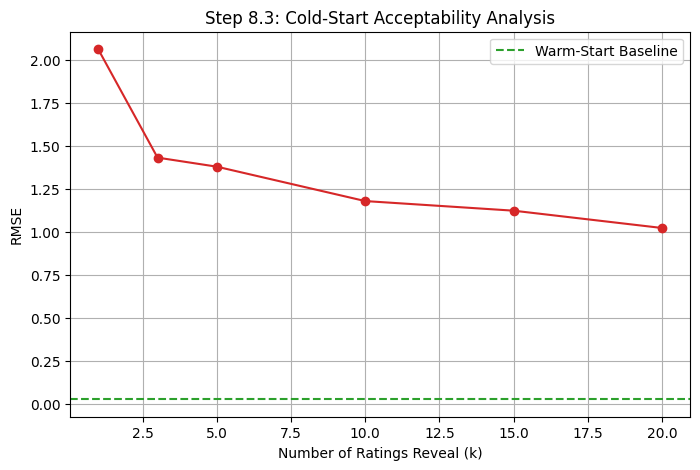

In [ ]:
rating_thresholds = [1, 3, 5, 10, 15, 20]
threshold_results = []

for n_known in rating_thresholds:
    errors_at_n = []
    for u in cold_start_users:
        # 1. Identify all items this user actually rated
        all_rated_items = np.where(~np.isnan(R_values[u, :]))[0]
        
        if len(all_rated_items) > n_known:
            # 2. Randomly select the 'n' ratings we want to reveal
            known_idx = np.random.choice(all_rated_items, n_known, replace=False)
            hidden_idx = np.setdiff1d(all_rated_items, known_idx)
            
            # 3. Create a temporary "partial" matrix for JUST this user
            # Start with all NaNs, then fill only the 'known' ratings
            R_temp_row = np.full(R_values.shape[1], np.nan)
            R_temp_row[known_idx] = R_values[u, known_idx]
            
            # Create a mock partial matrix (or just a 2D array with 1 row)
            # because predict_cold_user uses R_partial[u_idx, :]
            R_partial_mock = np.full(R_values.shape, np.nan)
            R_partial_mock[u, :] = R_temp_row
            
            # 4. Call your original function without changing it
            # It now receives 4 arguments: (u_idx, R_partial, Vk, Sk)
            pred_ratings = predict_cold_user(u, R_partial_mock, Vk, Sk)
            
            # 5. Evaluate on hidden items
            # Ensure pred_ratings isn't all zeros (fallback in your function)
            if np.any(pred_ratings):
                rmse = np.sqrt(mean_squared_error(R_values[u, hidden_idx], pred_ratings[hidden_idx]))
                errors_at_n.append(rmse)
    
    if errors_at_n:
        threshold_results.append({
            "n_ratings": n_known,
            "Avg_RMSE": np.mean(errors_at_n)
        })

# Create results table
df_thresholds = pd.DataFrame(threshold_results)
print(df_thresholds)

# Plotting the "Acceptability" curve
plt.figure(figsize=(8,5))
plt.plot(df_thresholds['n_ratings'], df_thresholds['Avg_RMSE'], marker='o', color='tab:red')
plt.axhline(y=np.mean(rmse_warm), color='tab:green', linestyle='--', label='Warm-Start Baseline')
plt.title("Step 8.3: Cold-Start Acceptability Analysis")
plt.xlabel("Number of Ratings Reveal (k)")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

8.4: Cold-Start Mitigation: Hybrid with Item Popularity

In [ ]:
# Load necessary data
R_matrix = pd.read_csv('../results/tables/Part_3/ratings_matrix_filled.csv', index_col=0)
ratings_df = pd.read_csv('../data/ratings.csv')
item_avg_ratings = pd.read_csv('../results/tables/stats_analysis/item_avg_ratings.csv')
target_users = pd.read_csv("../results/tables/stats_analysis/target_users.csv")
target_items = pd.read_csv("../results/tables/stats_analysis/target_items.csv")

# Load truncated SVD matrices (optimal k)
k = 50
Uk = pd.read_csv(f"../results/tables/Part_3/U_k_{k}.csv").values
Sk = pd.read_csv(f"../results/tables/Part_3/Sigma_k_{k}.csv").values
Vk = pd.read_csv(f"../results/tables/Part_3/V_k_{k}.csv").values

# Compute popularity (normalized 0-1)
item_pop = item_avg_ratings.set_index('movieId')['avg_rating']
item_pop = (item_pop - item_pop.min()) / (item_pop.max() - item_pop.min())

- Hybrid approach (combine SVD with item popularity) 

In [ ]:
def predict_hybrid_svd_pop(u_id, i_id, Uk, Sk, Vk, R_matrix, alpha=0.7):
    """
    Hybrid cold-start mitigation: combine SVD prediction with item popularity
    alpha: weight for SVD (0-1)
    """
    try:
        # Check if user/item exist
        u_idx = R_matrix.index.get_loc(u_id)
        i_idx = R_matrix.columns.get_loc(str(i_id))
        # SVD prediction
        svd_pred = Uk[u_idx, :] @ Sk @ Vk[i_idx, :].T
    except KeyError:
        svd_pred = np.nan

    # Item popularity fallback
    pop_pred = item_pop.get(i_id, 3.0)  # default 3 if missing

    # Weighted hybrid
    if np.isnan(svd_pred):
        return round(pop_pred, 2)
    else:
        return round(alpha*svd_pred + (1-alpha)*pop_pred, 2)


Content-based initialization of latent factors 

In [ ]:
import pandas as pd

# Load ratings subset
ratings = pd.read_csv("../data/ratings.csv")  # columns: userId, movieId, rating, timestamp

# Load full movies file
movies = pd.read_csv("../data/movies.csv")  # columns: movieId, title, genres

# Keep only movies in your ratings subset
movies_subset = movies[movies['movieId'].isin(ratings['movieId'].unique())].copy()
print(f"Number of movies in subset: {len(movies_subset)}")


Number of movies in subset: 900


In [ ]:
# Handle missing genres
movies_subset['genres'] = movies_subset['genres'].fillna('')

# One-hot encode genres
all_genres = set()
for g in movies_subset['genres']:
    all_genres.update(g.split('|'))
all_genres = sorted(all_genres)

for genre in all_genres:
    movies_subset[genre] = movies_subset['genres'].apply(lambda x: int(genre in x.split('|')))

# Final item feature matrix
item_features = movies_subset.set_index('movieId')[all_genres]
print(item_features.head())

         (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
movieId                                                                       
9                         0       1          0          0         0       0   
13                        0       0          1          1         1       0   
20                        0       1          0          0         0       1   
51                        0       1          0          0         0       0   
55                        0       0          0          0         0       0   

         Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  \
movieId                                                                         
9            0            0      0        0          0       0     0        0   
13           0            0      0        0          0       0     0        0   
20           1            0      1        0          0       0     0        0   
51           0            0      1       

In [ ]:
def initialize_cold_user_content(u_id, R_matrix, item_features_latent):
    """
    Initialize cold-start user latent vector by averaging latent features of rated items
    """
    rated_items = ratings_df[ratings_df['userId'] == u_id]['movieId']
    if len(rated_items) == 0:
        # No history -> average feature vector
        u_vec = item_features_latent.mean().values
    else:
        # Average latent features of rated items
        u_vec = item_features_latent.loc[rated_items].mean().values
    return u_vec

In [ ]:
def predict_cold_content(u_id, i_id, Uk, Sk, Vk, R_matrix, item_features):
    """
    Predict rating for cold-start user using content-based initialization
    """
    # User latent
    try:
        u_idx = R_matrix.index.get_loc(u_id)
        u_latent = Uk[u_idx, :]
    except KeyError:
        # Cold-start user
        rated_items = ratings_df[ratings_df['userId']==u_id]['movieId']
        # Only keep items that exist in item_features
        rated_items = [iid for iid in rated_items if iid in item_features.index]
        if len(rated_items) == 0:
            u_vec = item_features.mean().values
        else:
            u_vec = item_features.loc[rated_items].mean().values
        u_latent = u_vec

    # Item latent
    if i_id in R_matrix.columns:
        i_idx = R_matrix.columns.get_loc(i_id)
        i_latent = Vk[i_idx, :]
    else:
        # Cold-start item -> use average latent vector
        i_latent = Vk.mean(axis=0)

    rating = u_latent @ Sk @ i_latent.T
    return float(rating)


- Evaluate Improvement vs Baseline

In [ ]:
# Precompute average user latent vector for cold-start baseline
avg_user_latent = Uk.mean(axis=0)

baseline_preds = []
hybrid_preds = []
content_preds = []

for _, u_row in target_users.iterrows():
    for _, i_row in target_items.iterrows():
        uid = u_row['userId']
        iid = i_row['movieId']

        # --- Baseline SVD ---
        try:
            u_idx = R_matrix.index.get_loc(uid)
            u_latent = Uk[u_idx, :]
        except KeyError:
            # Cold-start user -> use average latent vector
            u_latent = avg_user_latent

        # Item latent
        try:
            i_idx = R_matrix.columns.get_loc(iid)
            i_latent = Vk[i_idx, :]
        except KeyError:
            # If item is unknown, use average item latent
            i_latent = Vk.mean(axis=0)

        # Predict
        pred_base = u_latent @ Sk @ i_latent.T
        baseline_preds.append(pred_base)

        # --- Hybrid ---
        pred_hybrid = predict_hybrid_svd_pop(uid, iid, Uk, Sk, Vk, R_matrix)
        hybrid_preds.append(pred_hybrid)

        # --- Content-based ---
        pred_content = predict_cold_content(uid, iid, Uk, Sk, Vk, R_matrix, item_features)
        content_preds.append(pred_content)

# Convert to DataFrame
eval_df = pd.DataFrame({
    "Baseline": baseline_preds,
    "Hybrid": hybrid_preds,
    "Content": content_preds
})

print(eval_df.head())

   Baseline  Hybrid   Content
0  3.439110    2.15  3.439110
1  3.439110    1.96  3.439110
2  3.449293    2.15  3.449293
3  3.449293    1.96  3.449293
4  3.392142    2.11  3.392142
